In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,concatenate,MaxPooling2D,Dropout
from tensorflow.keras.models import Model

IMG_WIDTH=448
IMG_HEIGHT=448
IMG_CHANNELS=3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
! unzip /content/drive/MyDrive/CrackImages.zip

Archive:  /content/drive/MyDrive/CrackImages.zip
replace CrackImages/test/images/CFD_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import numpy as np 

Original=os.listdir('/content/CrackImages/train/images')
Masks=os.listdir('/content/CrackImages/train/masks')

Original=Original[:901]
Masks=Masks[:901]

X=np.zeros((len(Original),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.float32)
y=np.zeros((len(Masks),IMG_HEIGHT,IMG_WIDTH,1), dtype=np.bool)


In [ ]:

import cv2

for file in Original:
    n=Original.index(file)
    path1=os.path.join('CrackImages/train/images',file)
    img=cv2.imread(path1,1)
    try:
        X[n]=img/255
        file2=Masks[n]
        path2=os.path.join('CrackImages/train/masks',file2)
        mask=cv2.imread(path2,1)
        mask=cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
        mask=np.expand_dims(mask,axis=2)
        y[n]=mask/255
    except Exception as e:
        print(e)
        print(path1)

In [ ]:
from sklearn import model_selection
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.15,random_state=42)

In [ ]:
inputs=tf.keras.layers.Input((448,448,3))


s = inputs


c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c2 = Dropout(0.2)(c2)  # Original 0.1
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.2)(c8)  # Original 0.1
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
  
 
outputs = Conv2D(1,(1, 1),activation='sigmoid')(c8)
 
model = Model(inputs=[inputs], outputs=[outputs])

#NOTE: Compile the model in the main program to make it easy to test with various loss functions
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

####################################################################
# Model Checkpoint
checkpoint=tf.keras.callbacks.ModelCheckpoint('crack_model.h5',verbose=1,save_best_only=True)
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(log_dir='logs')]

results=model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=5,epochs=10,callbacks=callbacks)





Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 448, 448, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 448, 448, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 448, 448, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.save('/content/drive/MyDrive/final_model.h5')

In [ ]:
new_model=tf.keras.models.load_model('/content/drive/MyDrive/final_model.h5')

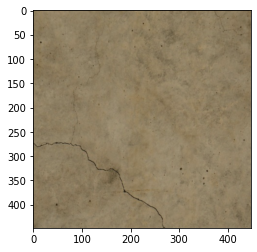

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_test[59])

In [ ]:
img=np.expand_dims(X_test[59],axis=0)

In [ ]:
img.shape

(1, 448, 448, 3)

In [ ]:
pred=new_model.predict(img)

In [ ]:
pred.shape

(1, 448, 448, 1)

In [ ]:
pred_0=cv2.resize(pred[0],(512,512))

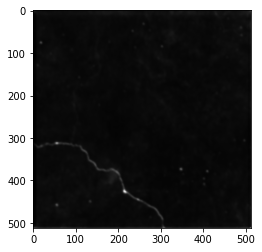

In [ ]:
plt.imshow(pred_0,cmap='gray')

In [ ]:
pred

array([[[41.539722 , 41.539722 , 41.539722 ],
        [36.416187 , 36.416187 , 36.416187 ],
        [27.651375 , 27.651375 , 27.651375 ],
        ...,
        [12.344861 , 12.344861 , 12.344861 ],
        [16.36306  , 16.36306  , 16.36306  ],
        [20.884224 , 20.884224 , 20.884224 ]],

       [[29.74235  , 29.74235  , 29.74235  ],
        [29.160233 , 29.160233 , 29.160233 ],
        [25.631521 , 25.631521 , 25.631521 ],
        ...,
        [11.119928 , 11.119928 , 11.119928 ],
        [12.948309 , 12.948309 , 12.948309 ],
        [15.345118 , 15.345118 , 15.345118 ]],

       [[23.539406 , 23.539406 , 23.539406 ],
        [24.412462 , 24.412462 , 24.412462 ],
        [22.602654 , 22.602654 , 22.602654 ],
        ...,
        [ 8.896374 ,  8.896374 ,  8.896374 ],
        [10.256702 , 10.256702 , 10.256702 ],
        [12.257647 , 12.257647 , 12.257647 ]],

       ...,

       [[ 9.83979  ,  9.83979  ,  9.83979  ],
        [ 9.6050005,  9.6050005,  9.6050005],
        [ 8.583107 ,  